In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [12]:
df = pd.read_csv(
  "typicalyear.csv", 
  parse_dates=['timestamp'], 
  index_col="timestamp"
)

In [13]:
df.shape

(35112, 1)

In [14]:
df.head()

,value
timestamp,
2017-05-10 00:00:00+09:00,0.0
2017-05-10 01:00:00+09:00,0.0
2017-05-10 02:00:00+09:00,0.0
2017-05-10 03:00:00+09:00,0.0
2017-05-10 04:00:00+09:00,0.0


In [15]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['value'] = df['value'] * 100

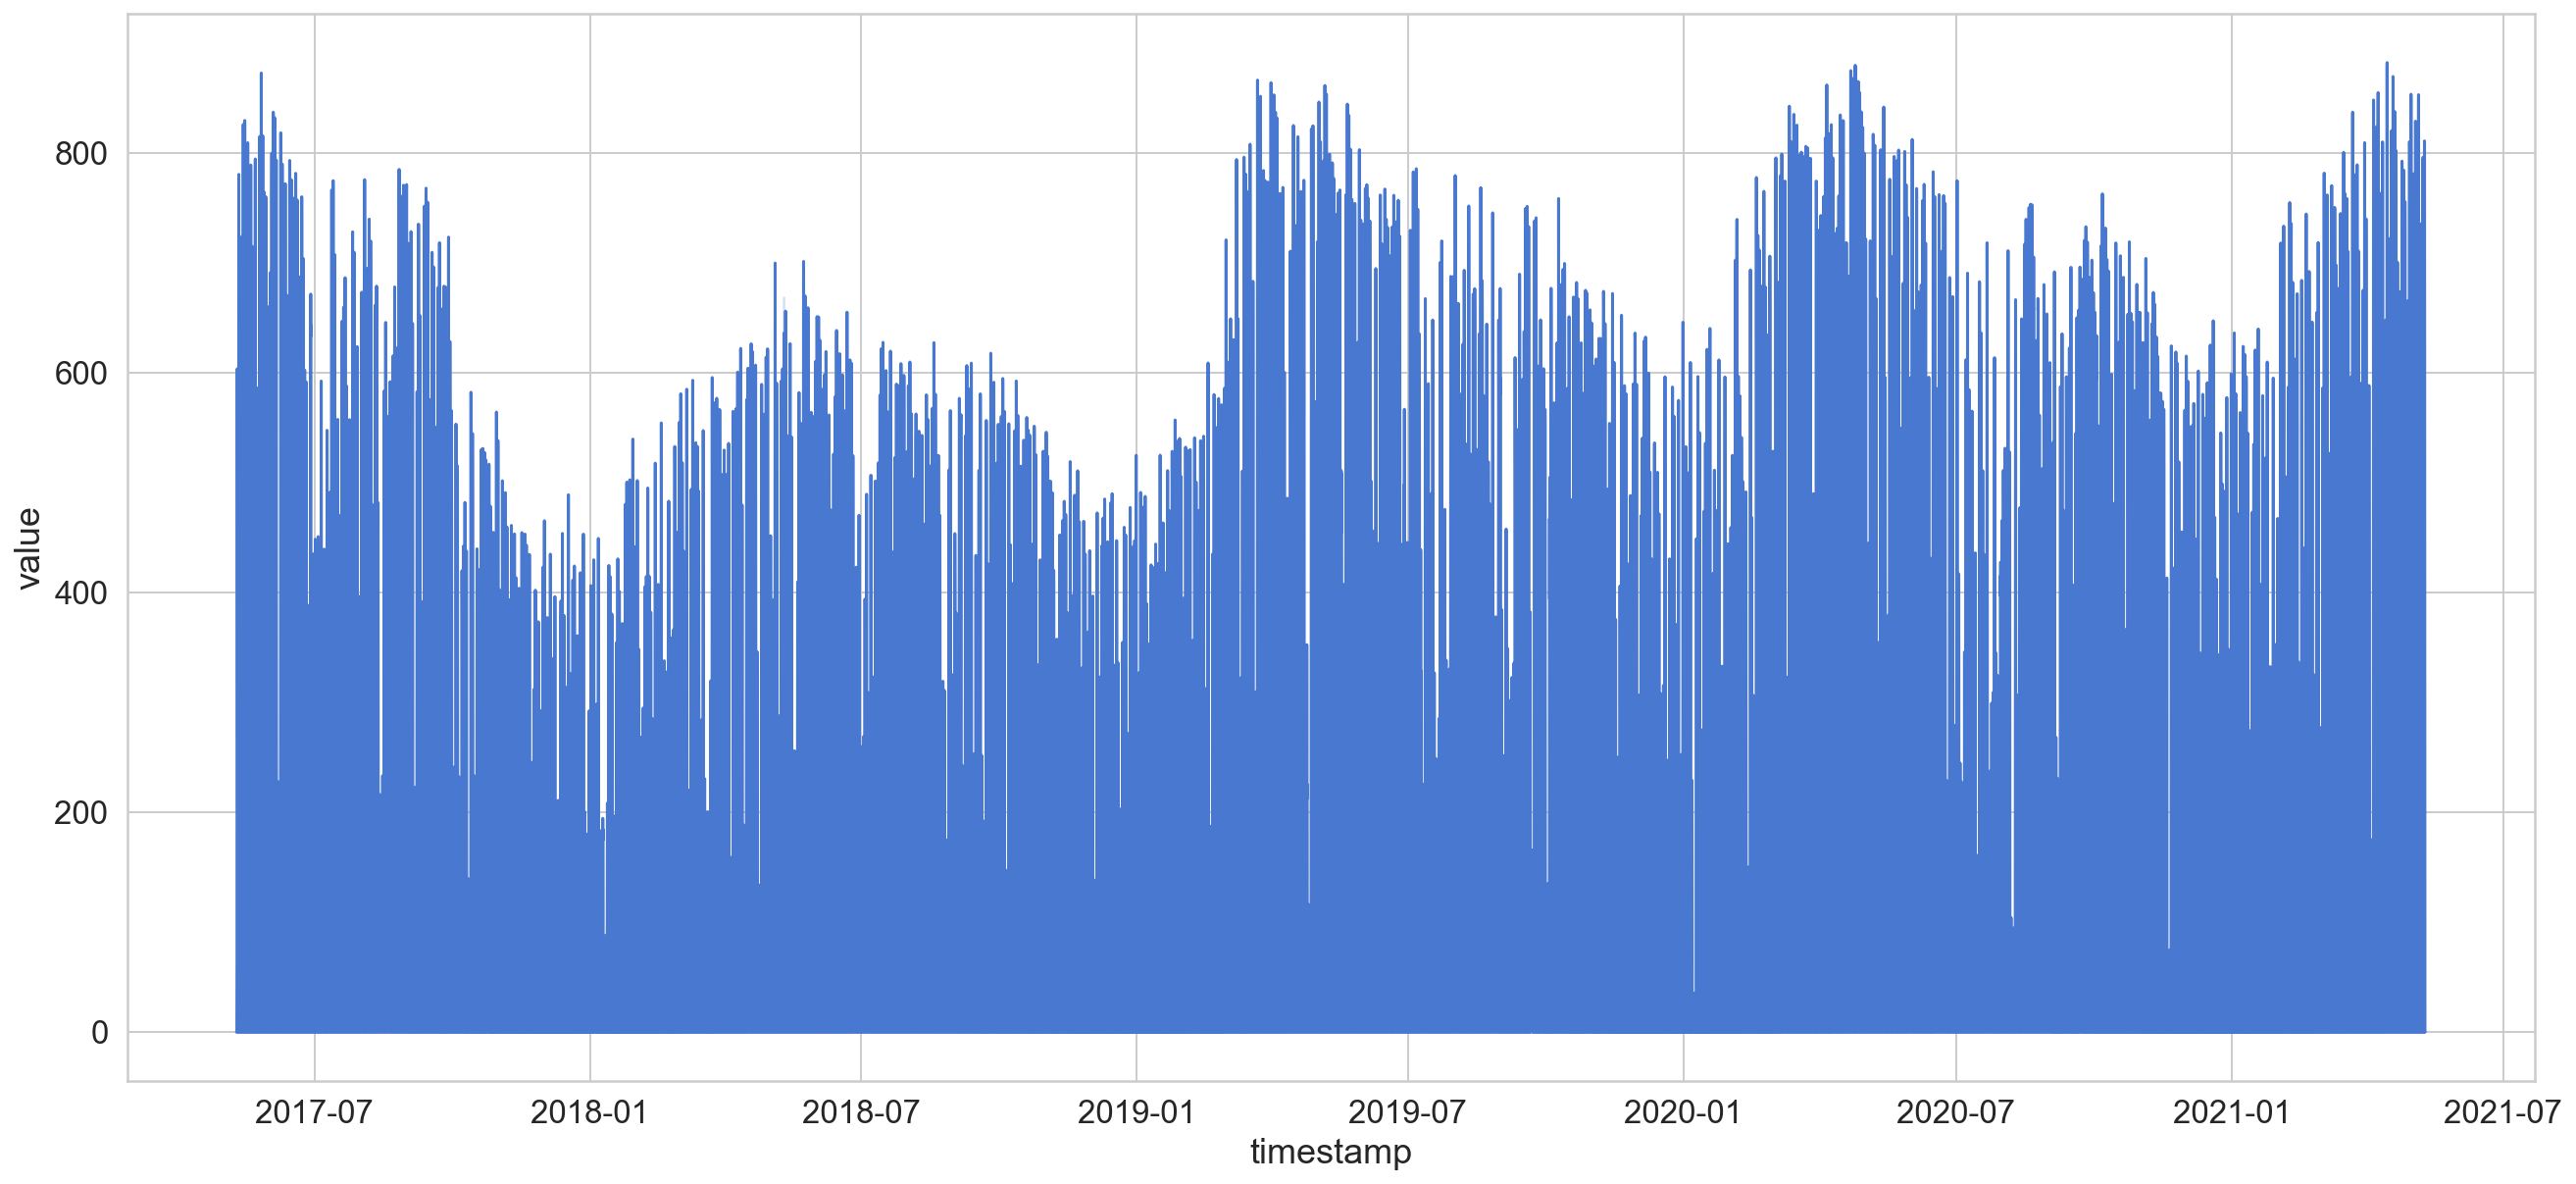

In [16]:
sns.lineplot(x=df.index, y="value", data=df);

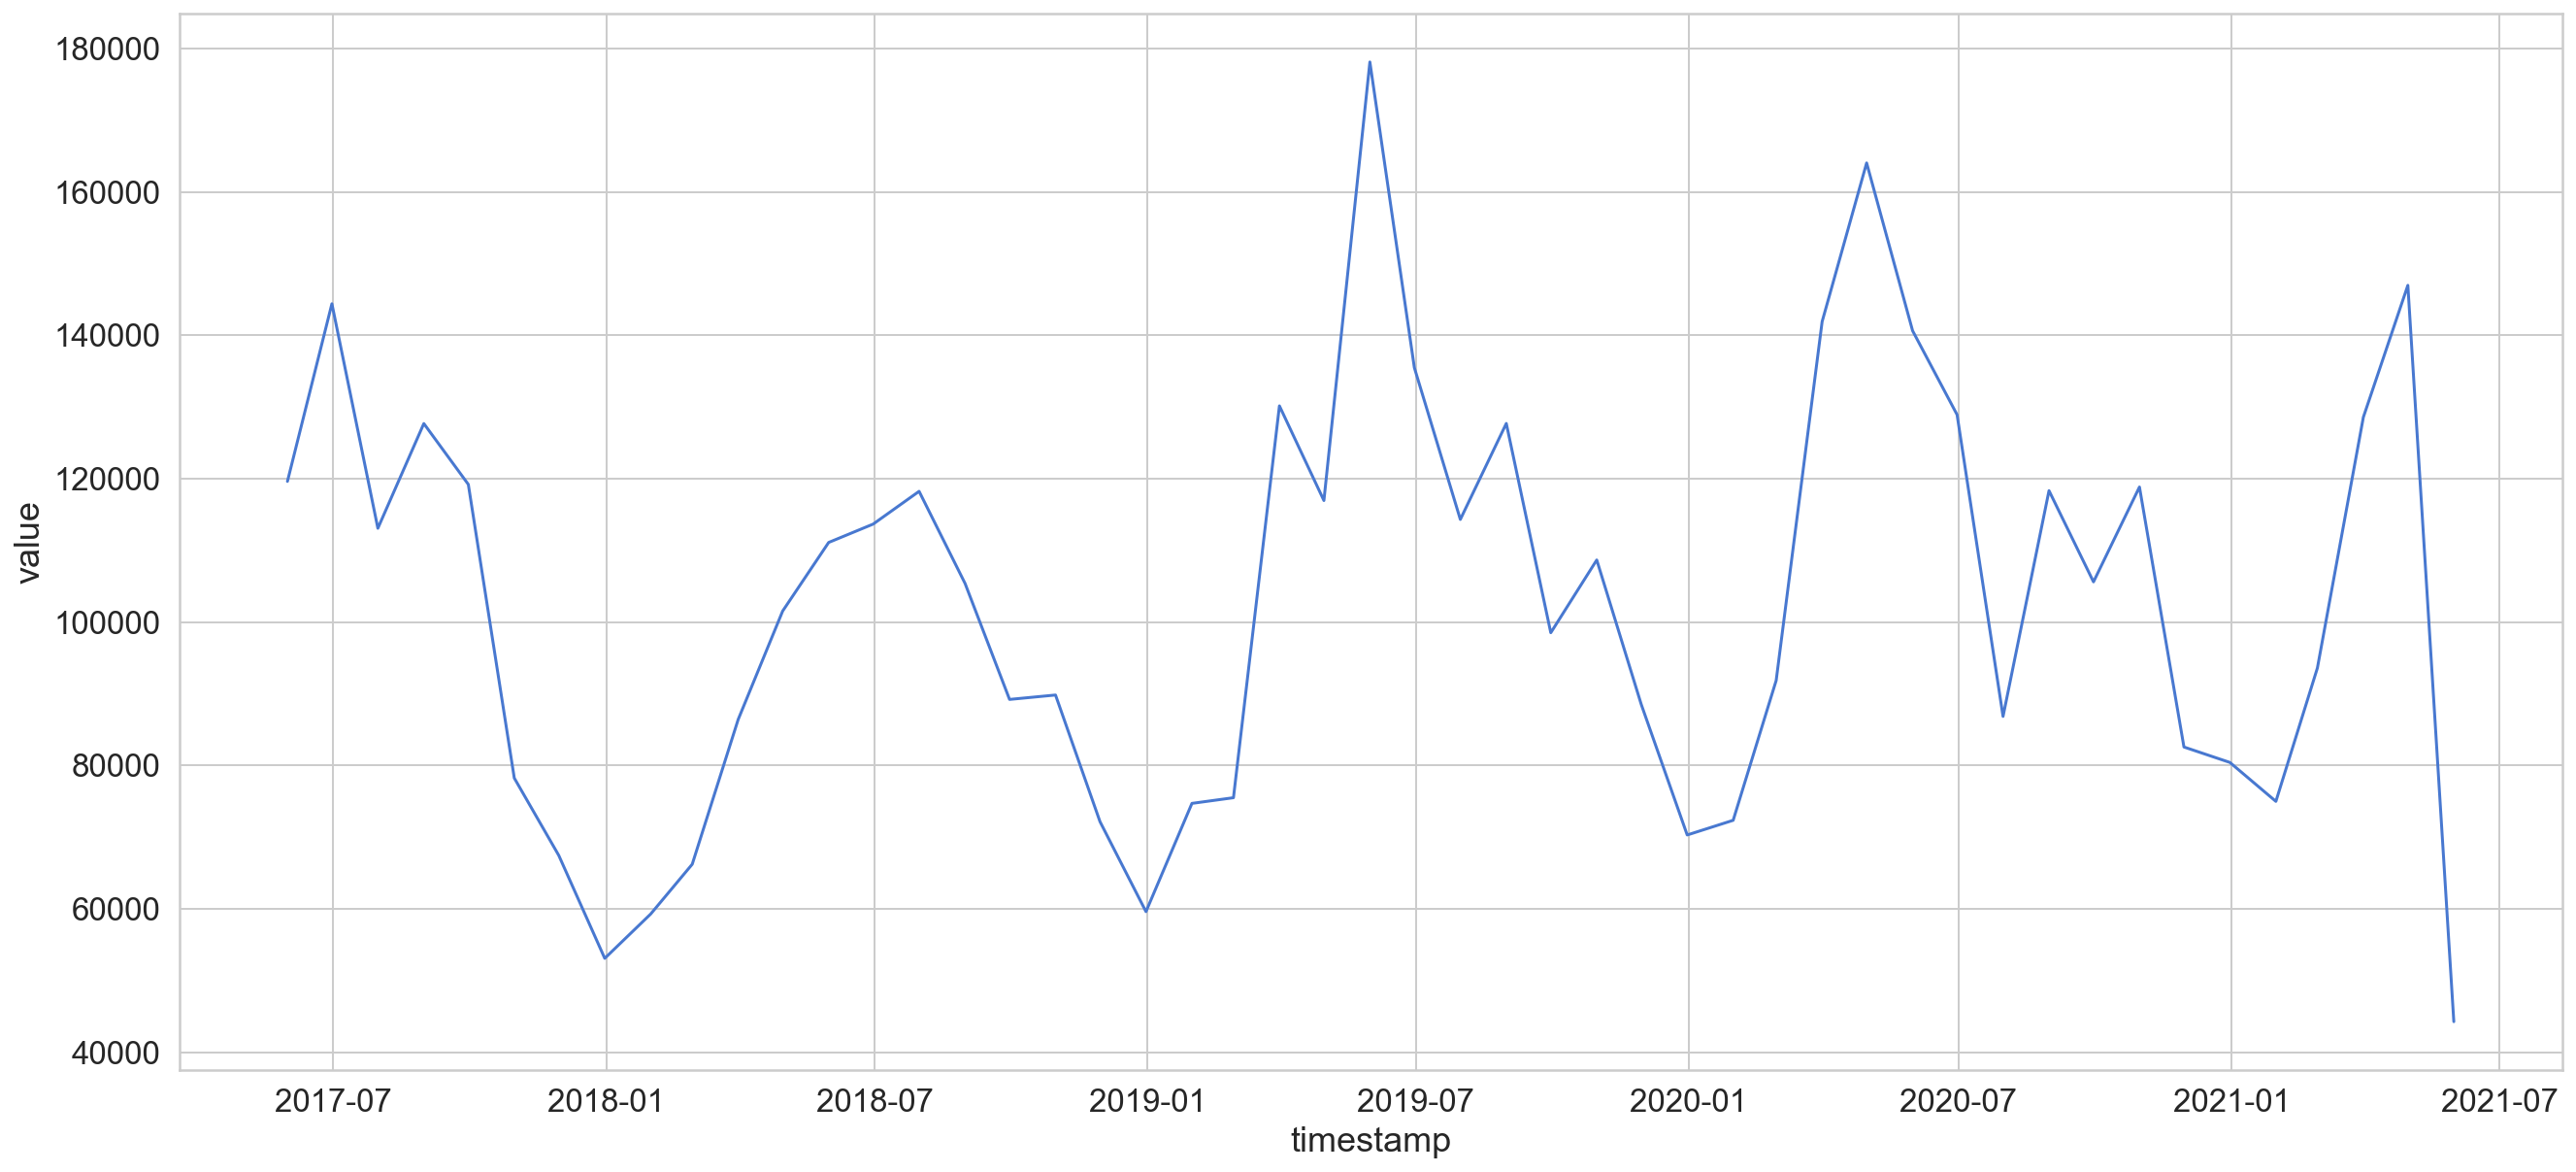

In [17]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="value", data=df_by_month)

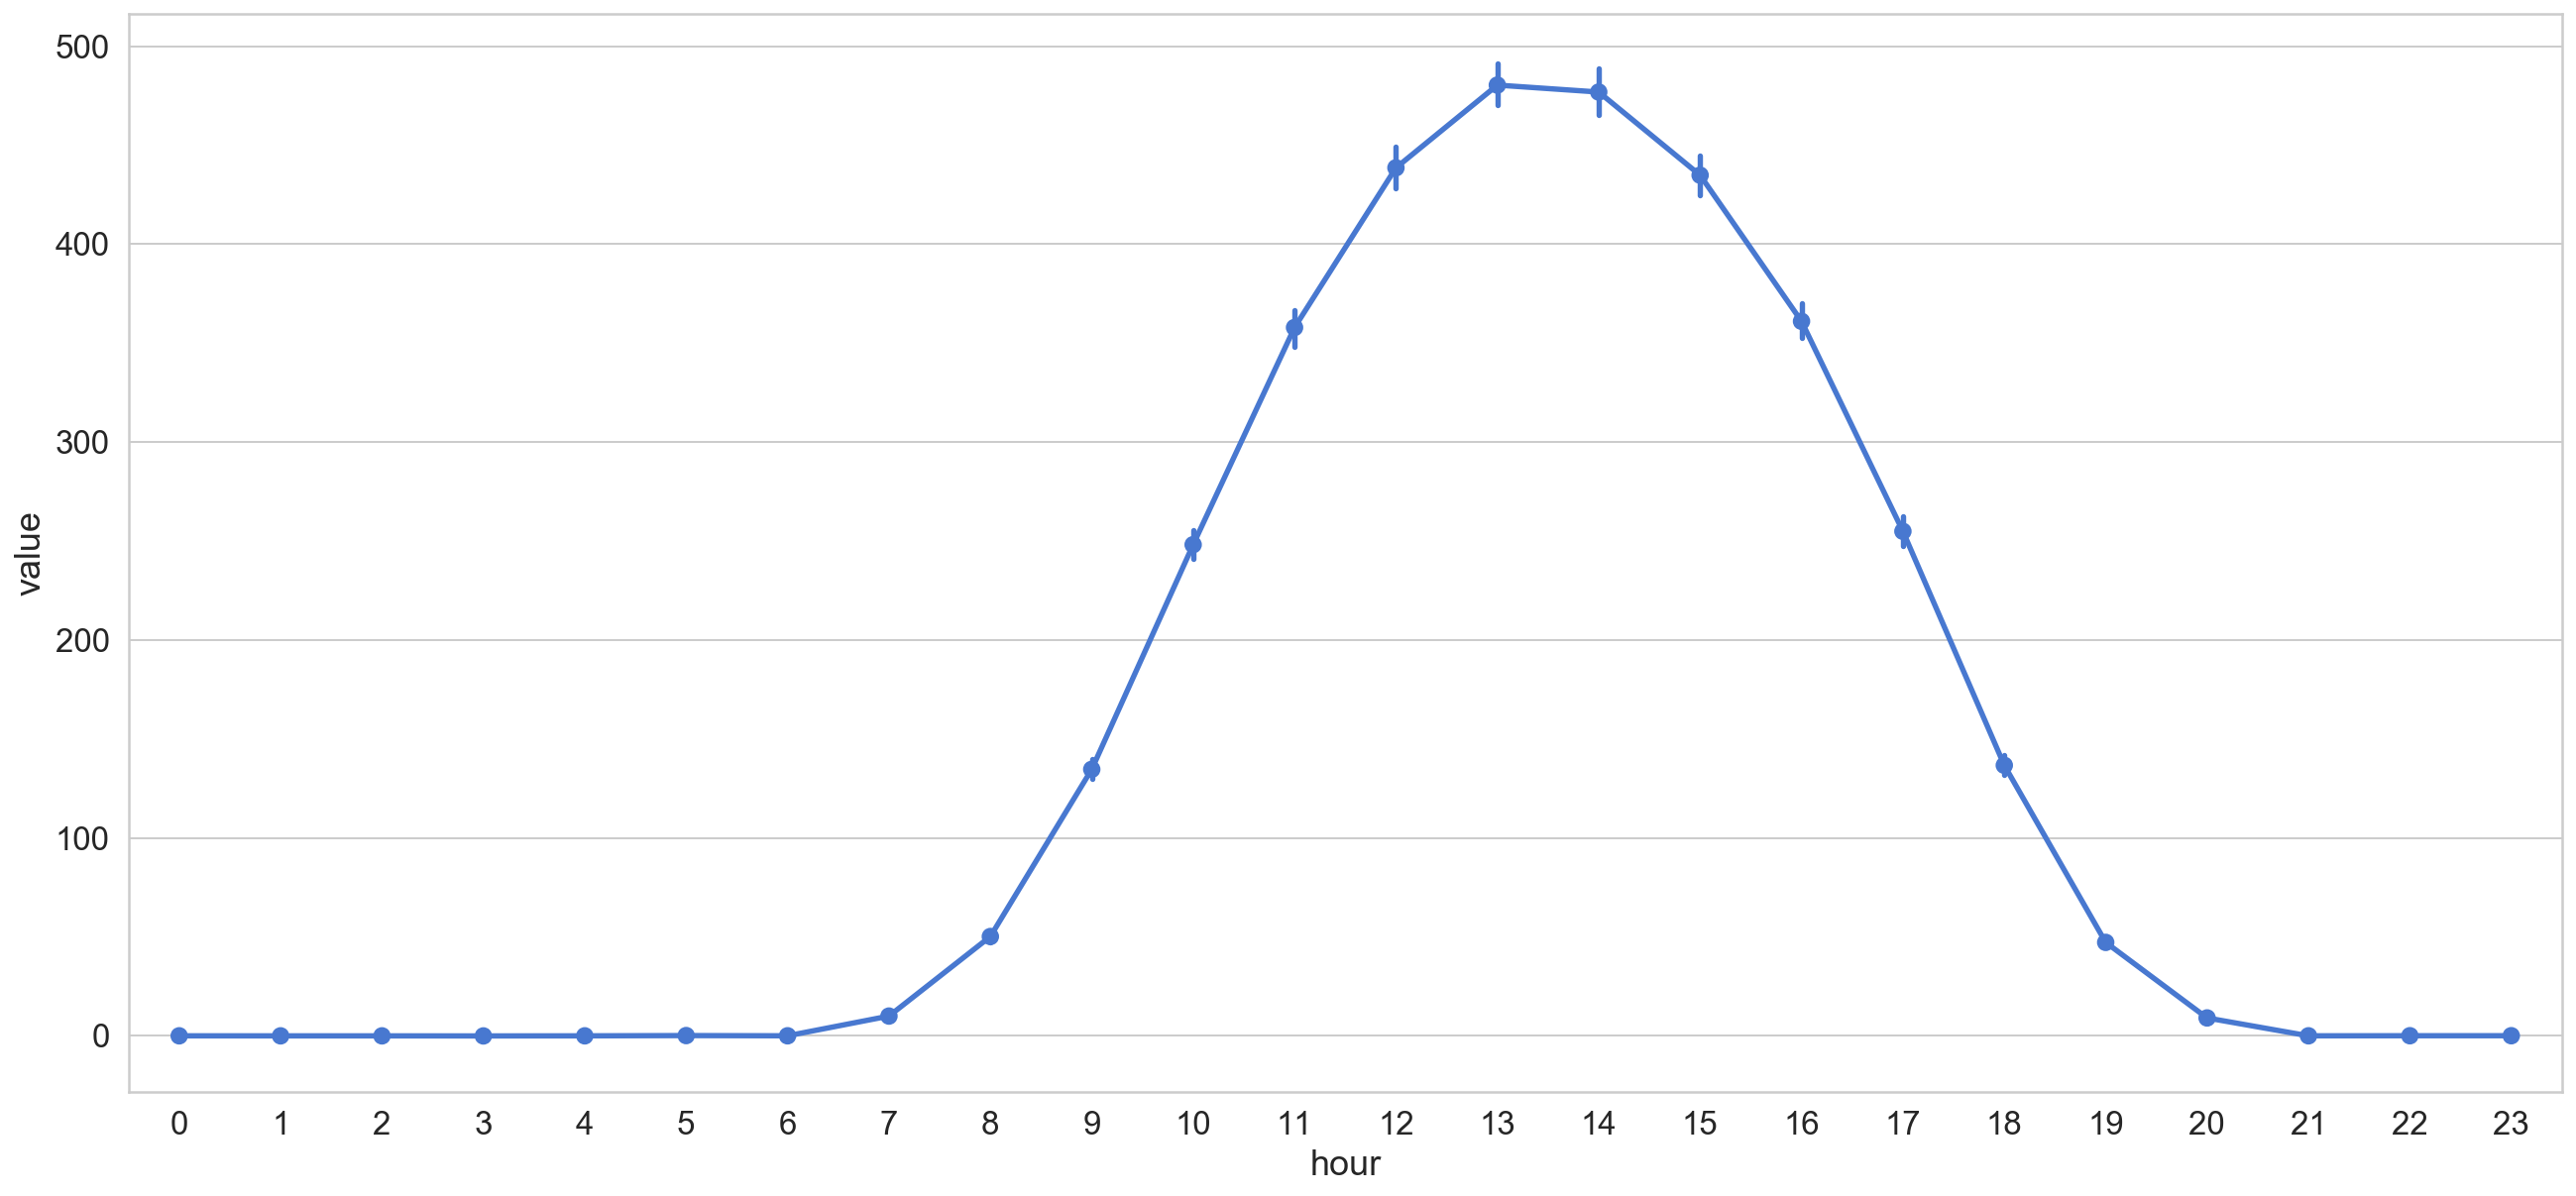

In [21]:
fig,(ax1)= plt.subplots(nrows=1)
# fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='value', ax=ax1)

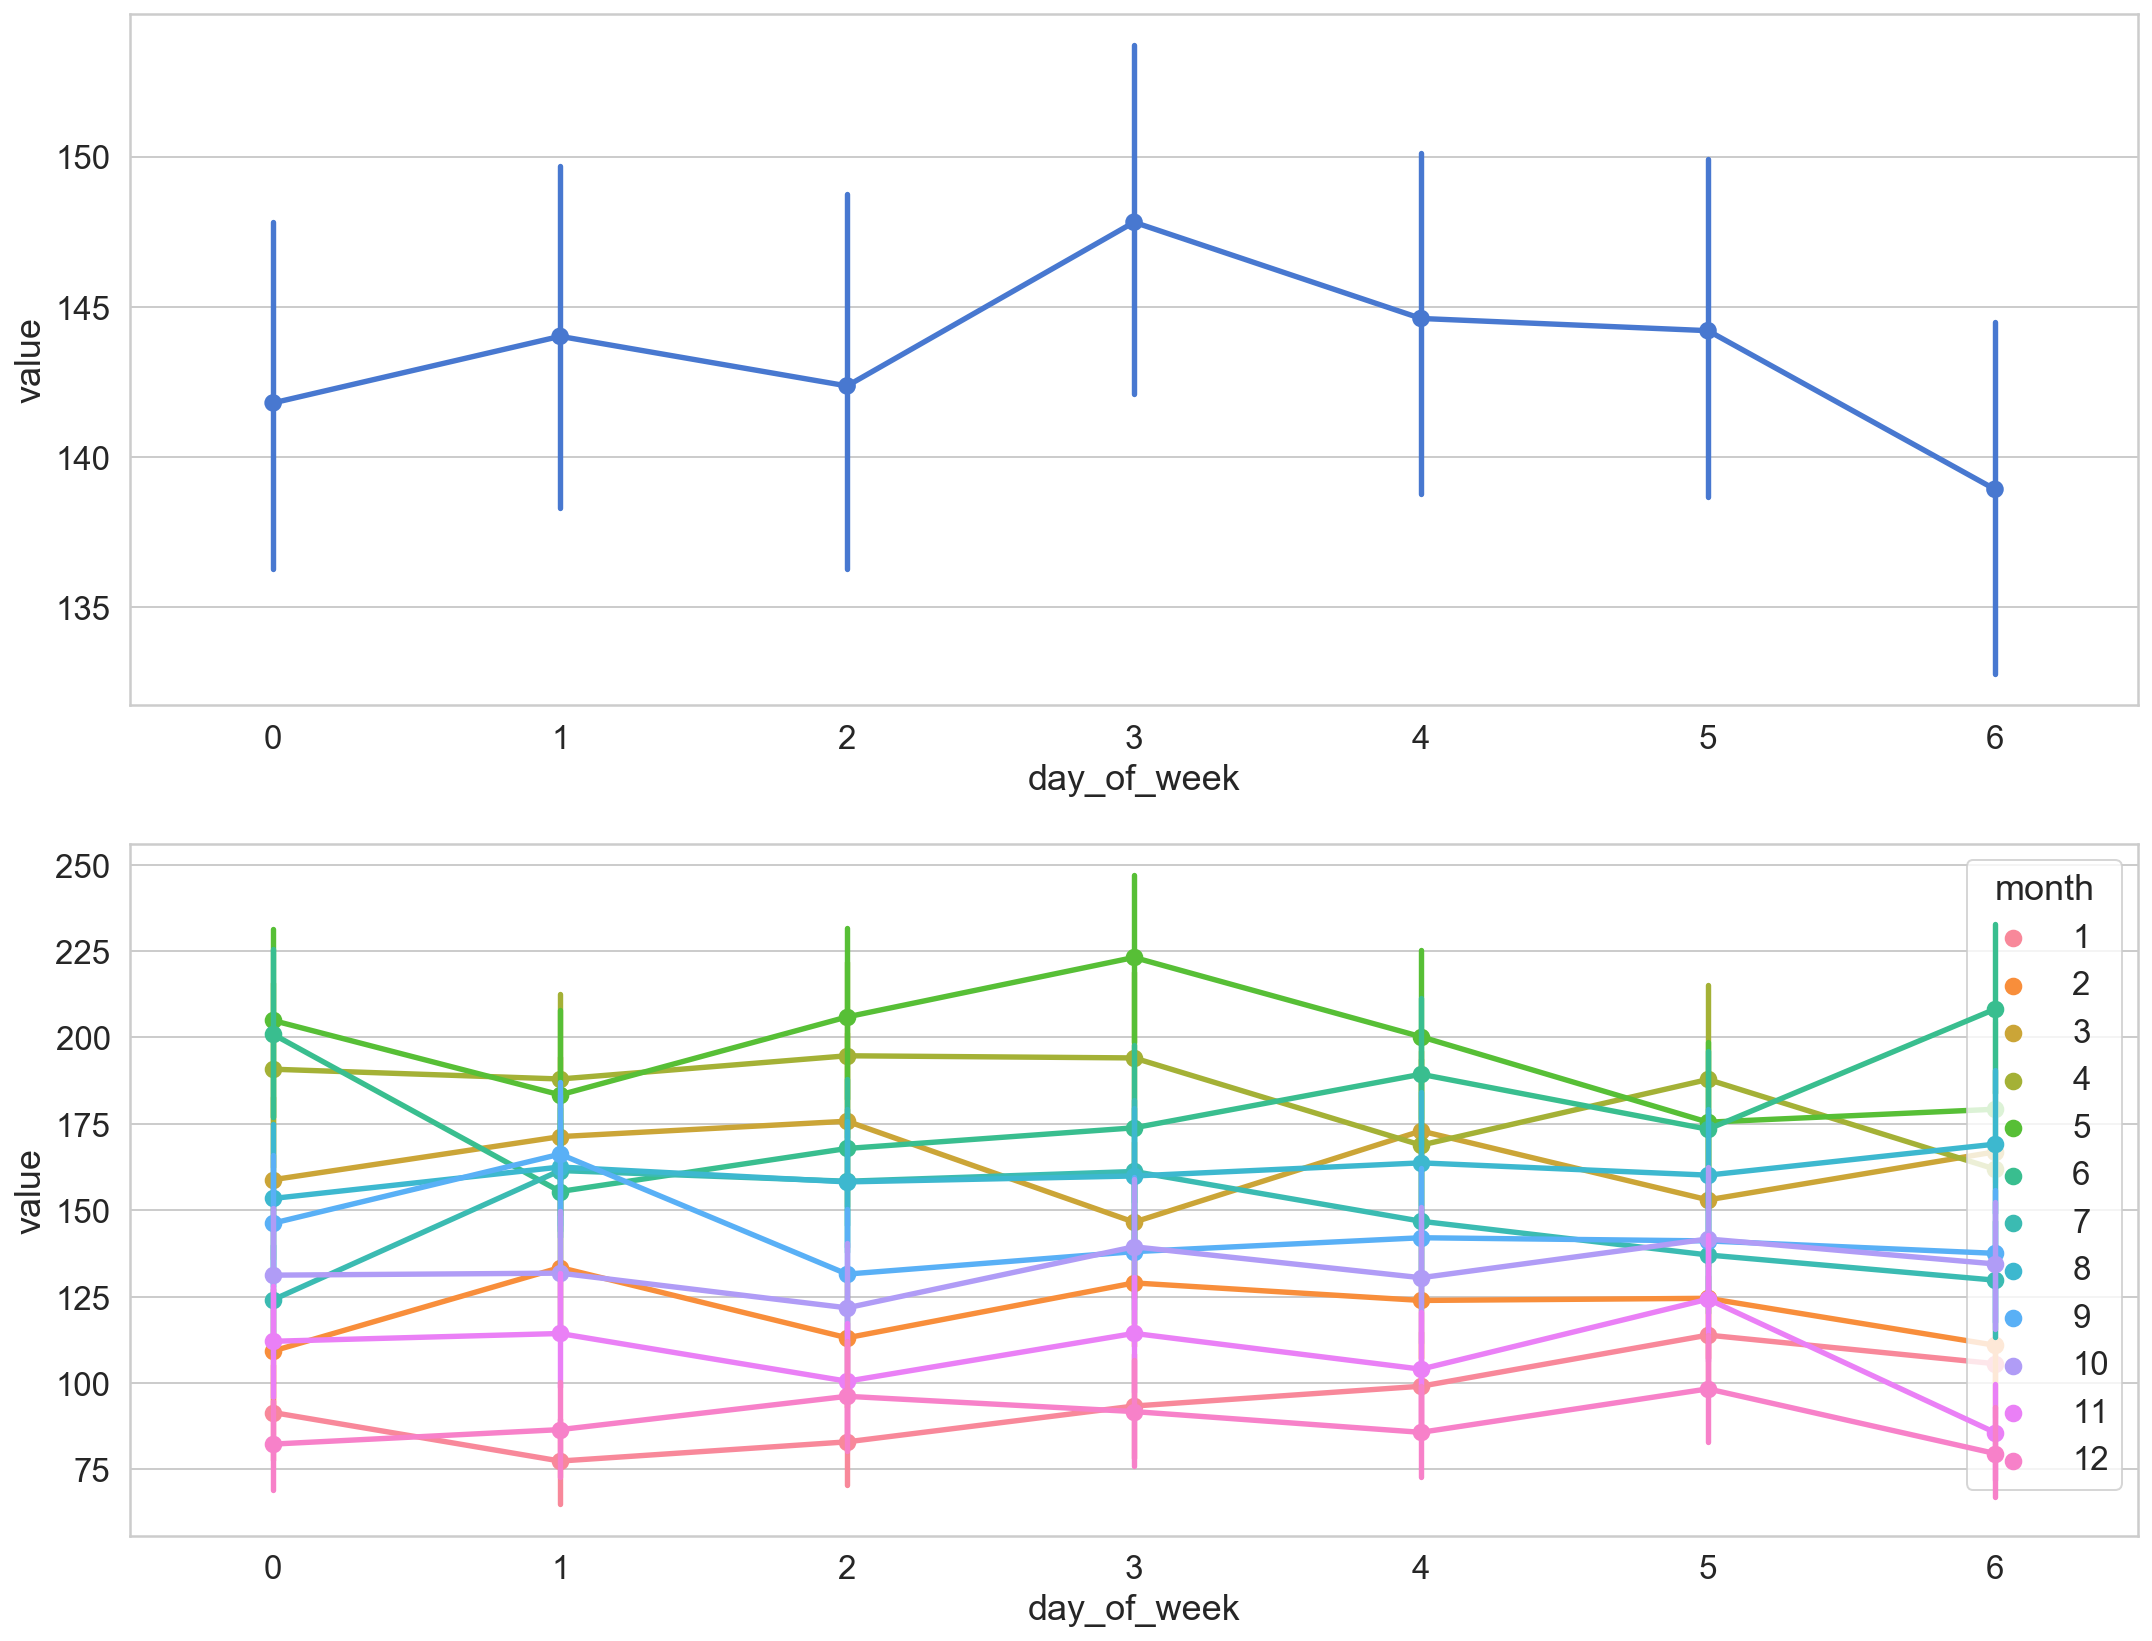

In [25]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='value', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='value', hue='month', ax=ax2);

In [26]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

31600 3512


In [27]:
from sklearn.preprocessing import RobustScaler

f_columns = ['month']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['value']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['value'] = cnt_transformer.transform(train[['value']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['value'] = cnt_transformer.transform(test[['value']])

/Users/sj.hyeon/development/env/python36/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/sj.hyeon/development/env/python36/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/sj.hyeon/development/env/python36/lib/python3.6/site-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [28]:

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [30]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.value, time_steps)
X_test, y_test = create_dataset(test, test.value, time_steps)

print(X_train.shape, y_train.shape)

(31590, 10, 5) (31590,)


In [31]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
889/889 [==============================] - 9s 7ms/step - loss: 0.3779 - val_loss: 0.0618
Epoch 2/30
889/889 [==============================] - 6s 7ms/step - loss: 0.0499 - val_loss: 0.0208
Epoch 3/30
889/889 [==============================] - 6s 7ms/step - loss: 0.0202 - val_loss: 0.0172
Epoch 4/30
889/889 [==============================] - 7s 8ms/step - loss: 0.0163 - val_loss: 0.0159
Epoch 5/30
889/889 [==============================] - 7s 8ms/step - loss: 0.0135 - val_loss: 0.0140
Epoch 6/30
889/889 [==============================] - 8s 8ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 7/30
889/889 [==============================] - 7s 8ms/step - loss: 0.0120 - val_loss: 0.0104
Epoch 8/30
889/889 [==============================] - 7s 8ms/step - loss: 0.0114 - val_loss: 0.0121
Epoch 9/30
889/889 [==============================] - 10s 12ms/step - loss: 0.0107 - val_loss: 0.0119
Epoch 10/30
889/889 [==============================] - 14s 16ms/step - loss: 0.0116 - val_loss: 0.

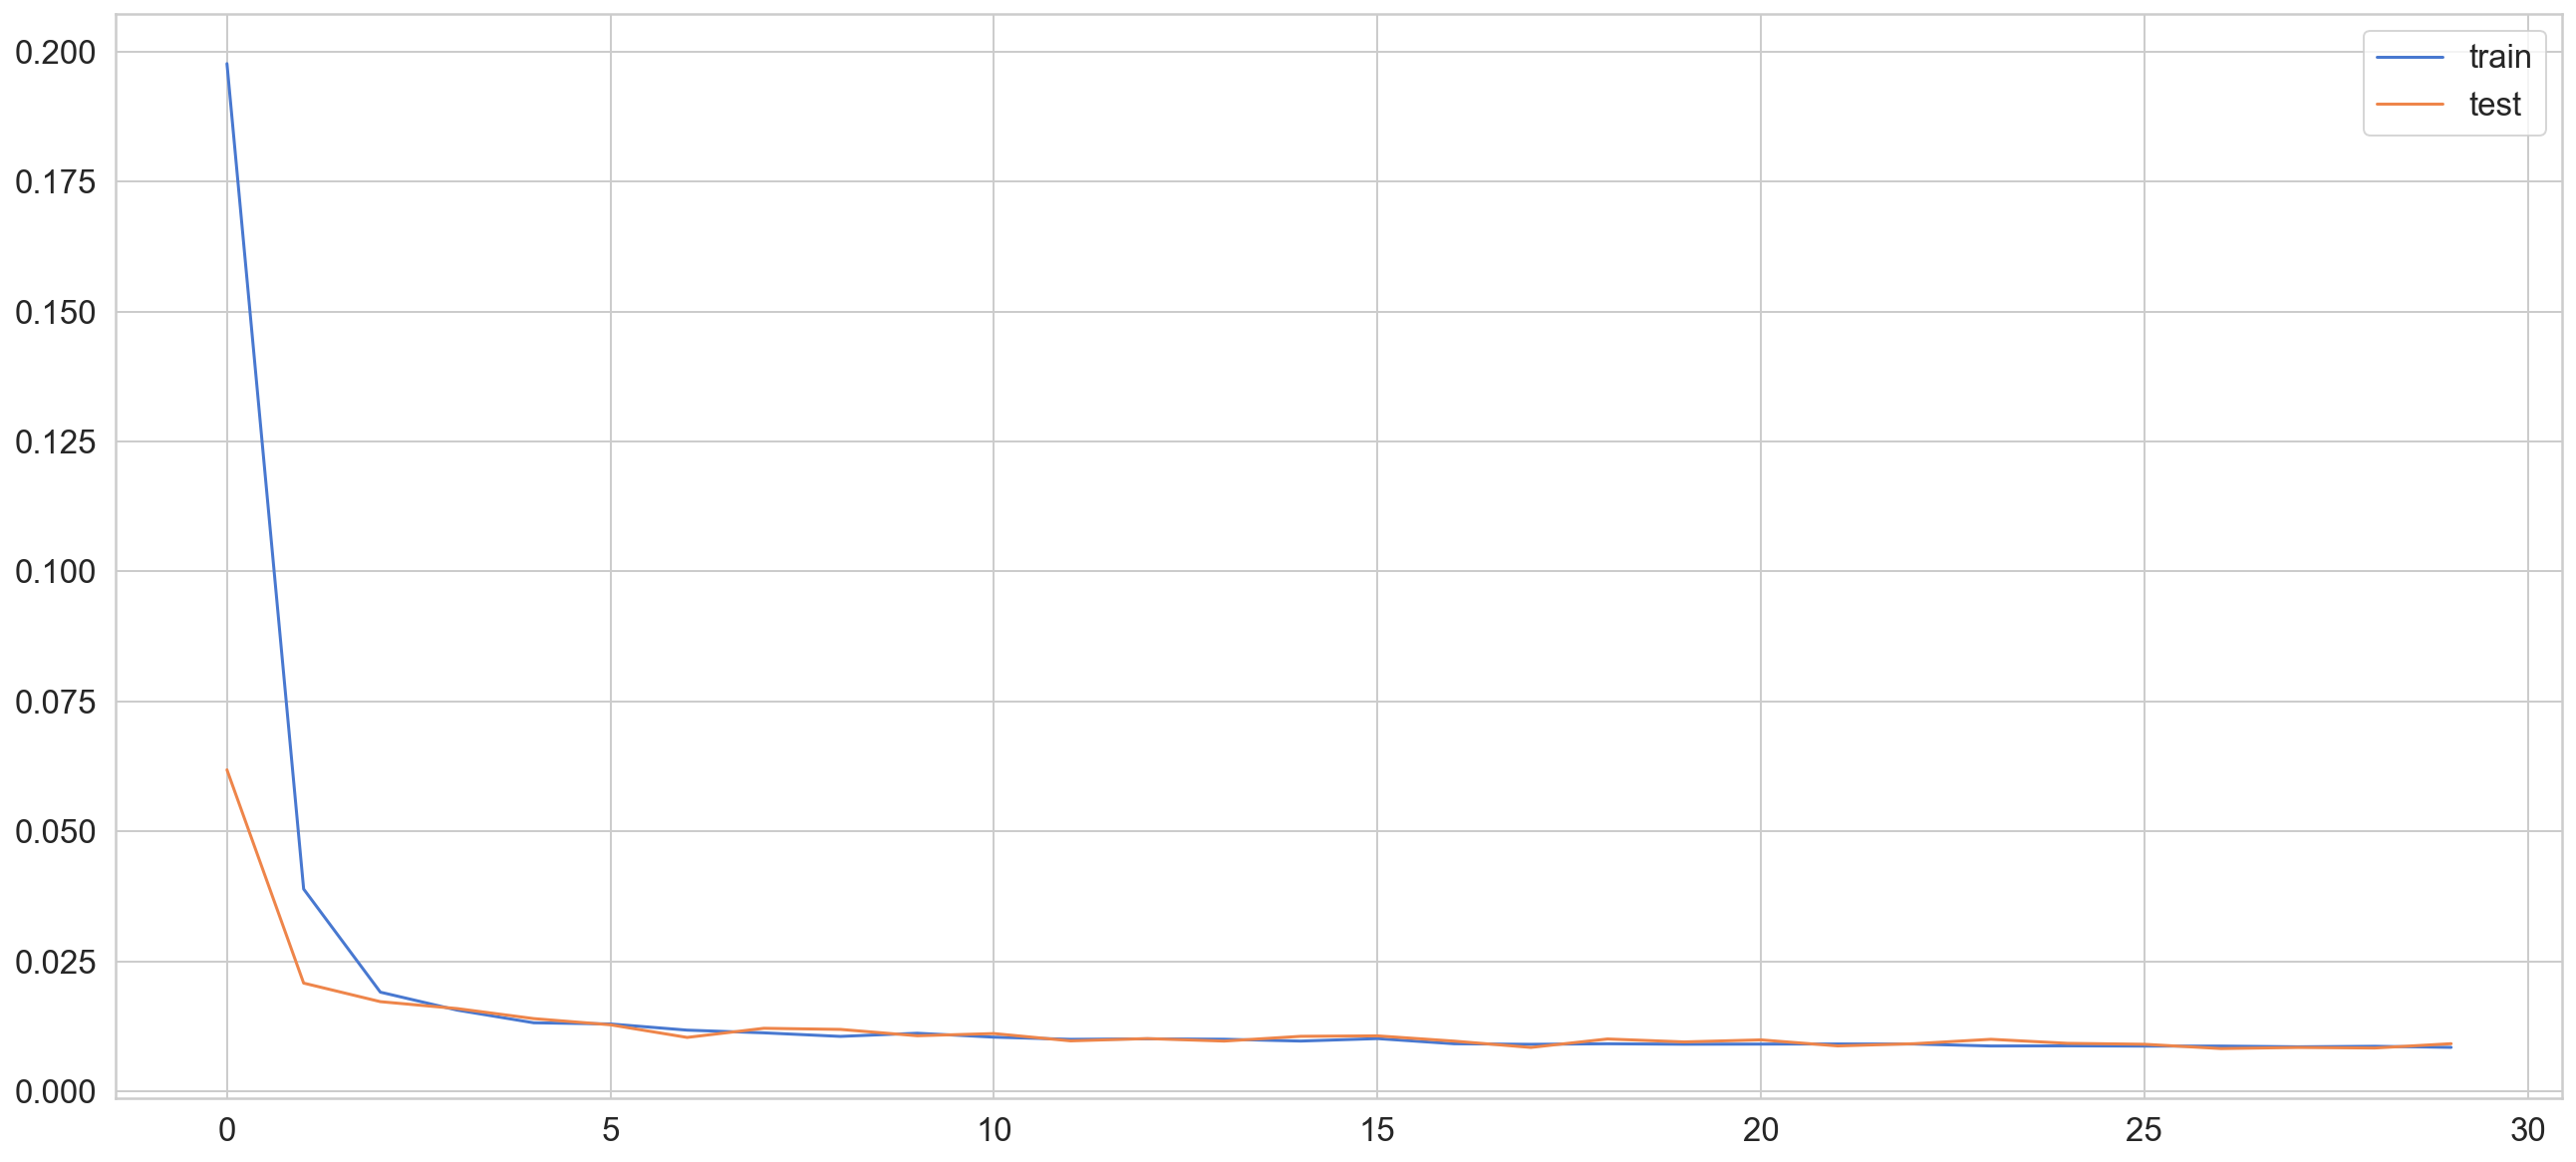

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [34]:
y_pred = model.predict(X_test)

In [46]:
y_pred[y_pred < 0] = 0

In [41]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

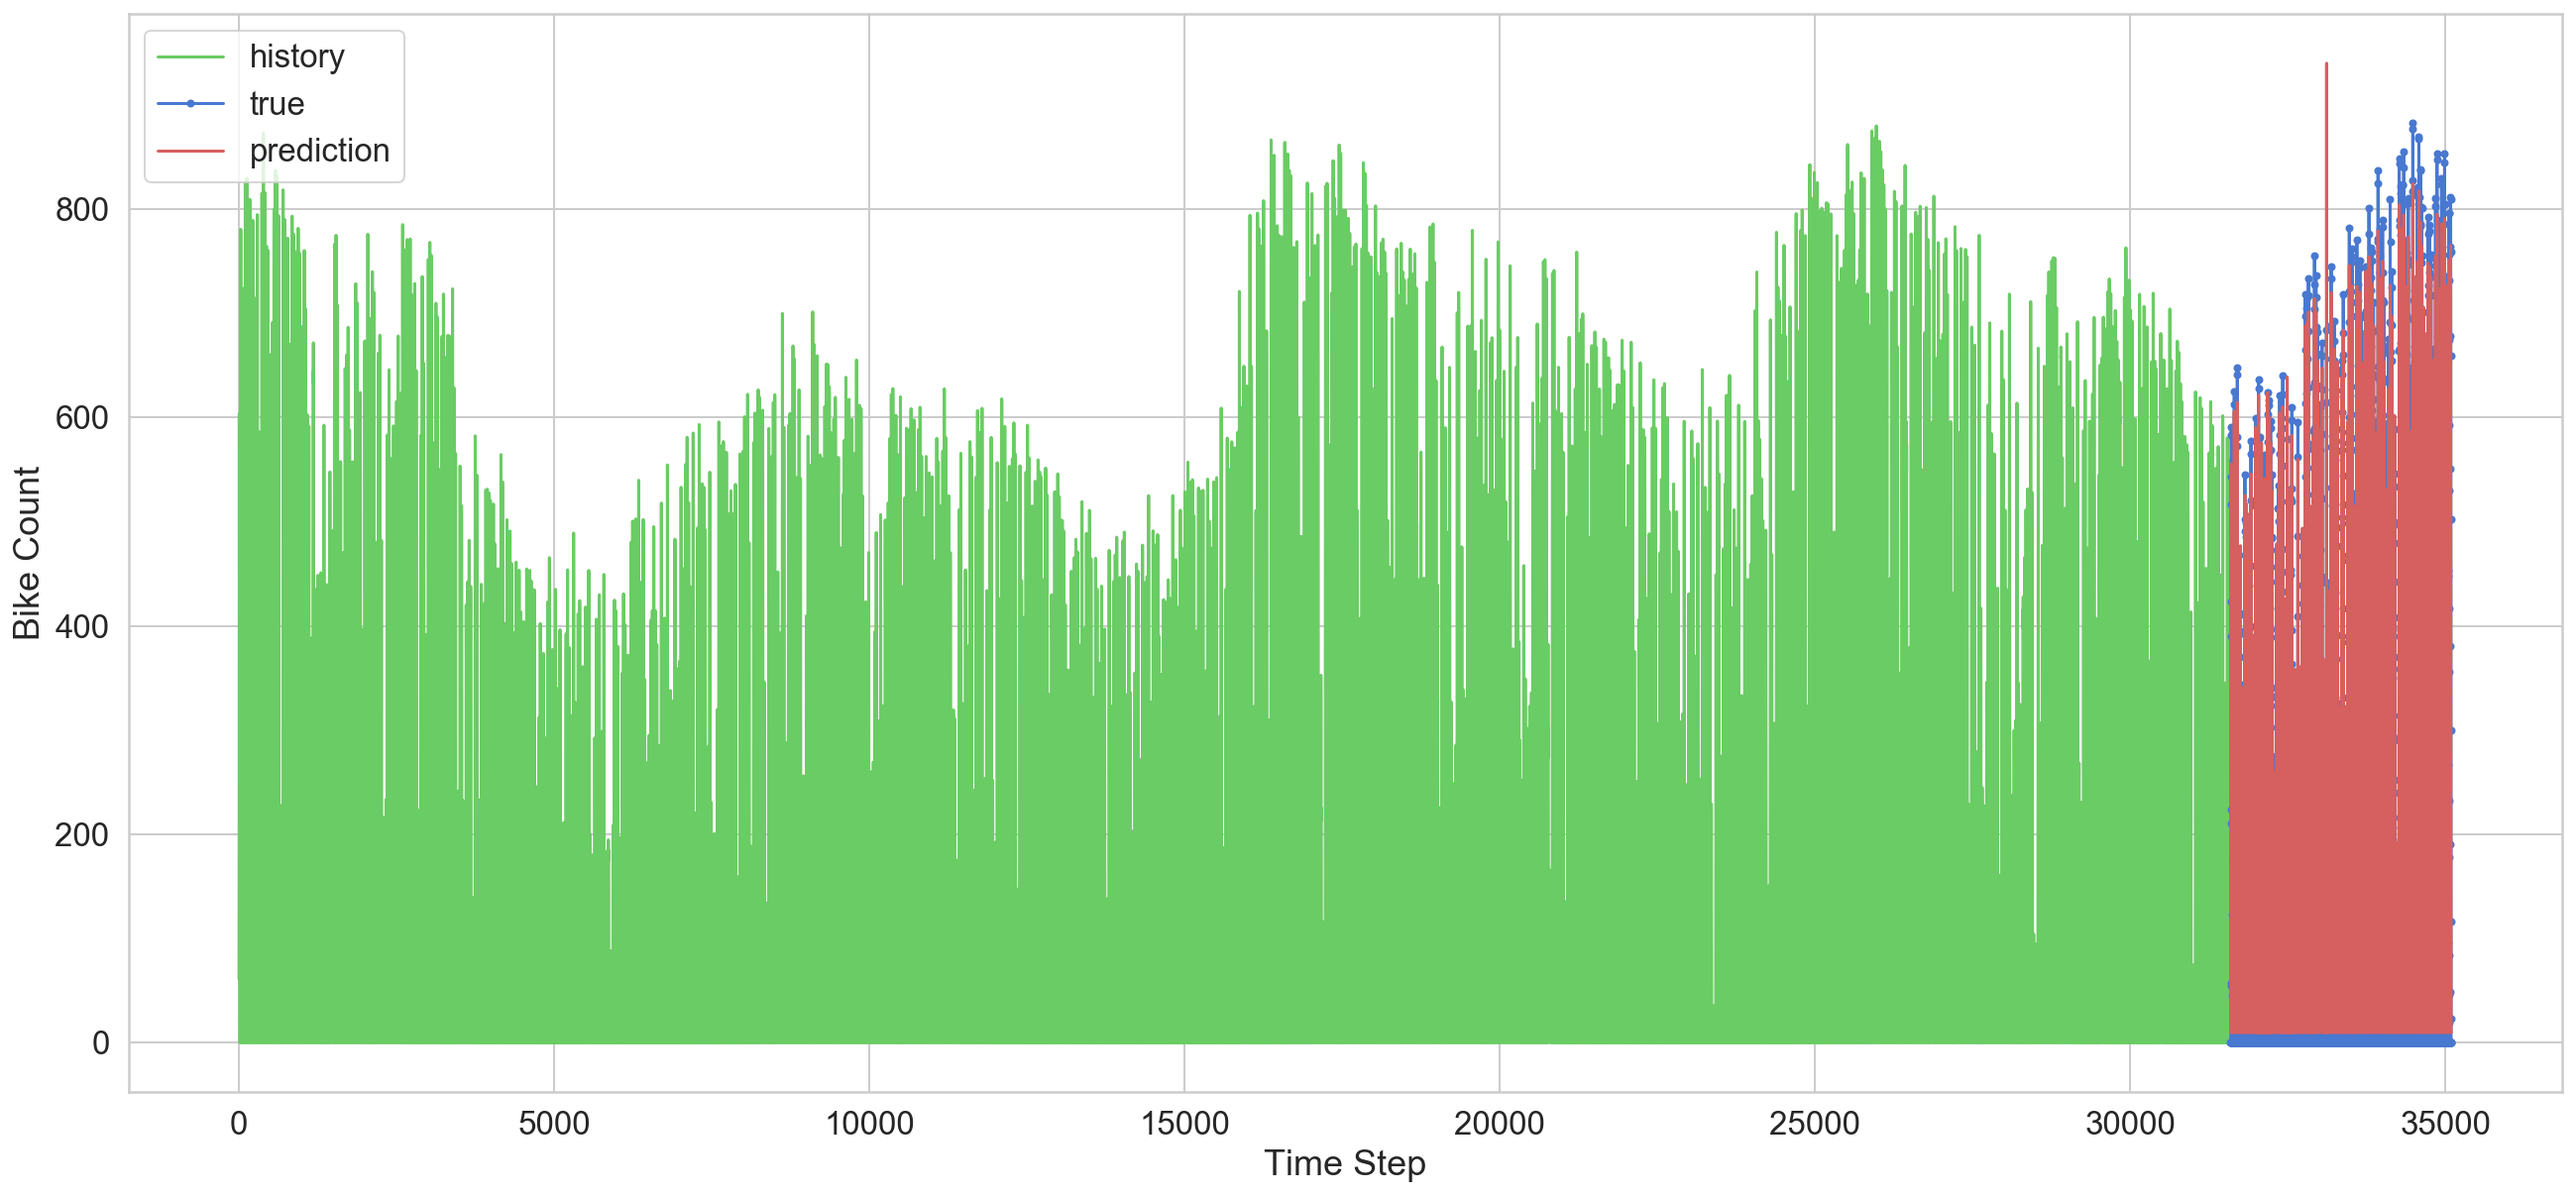

In [42]:

plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('value predict')
plt.xlabel('Time Step')
plt.legend()
plt.show();

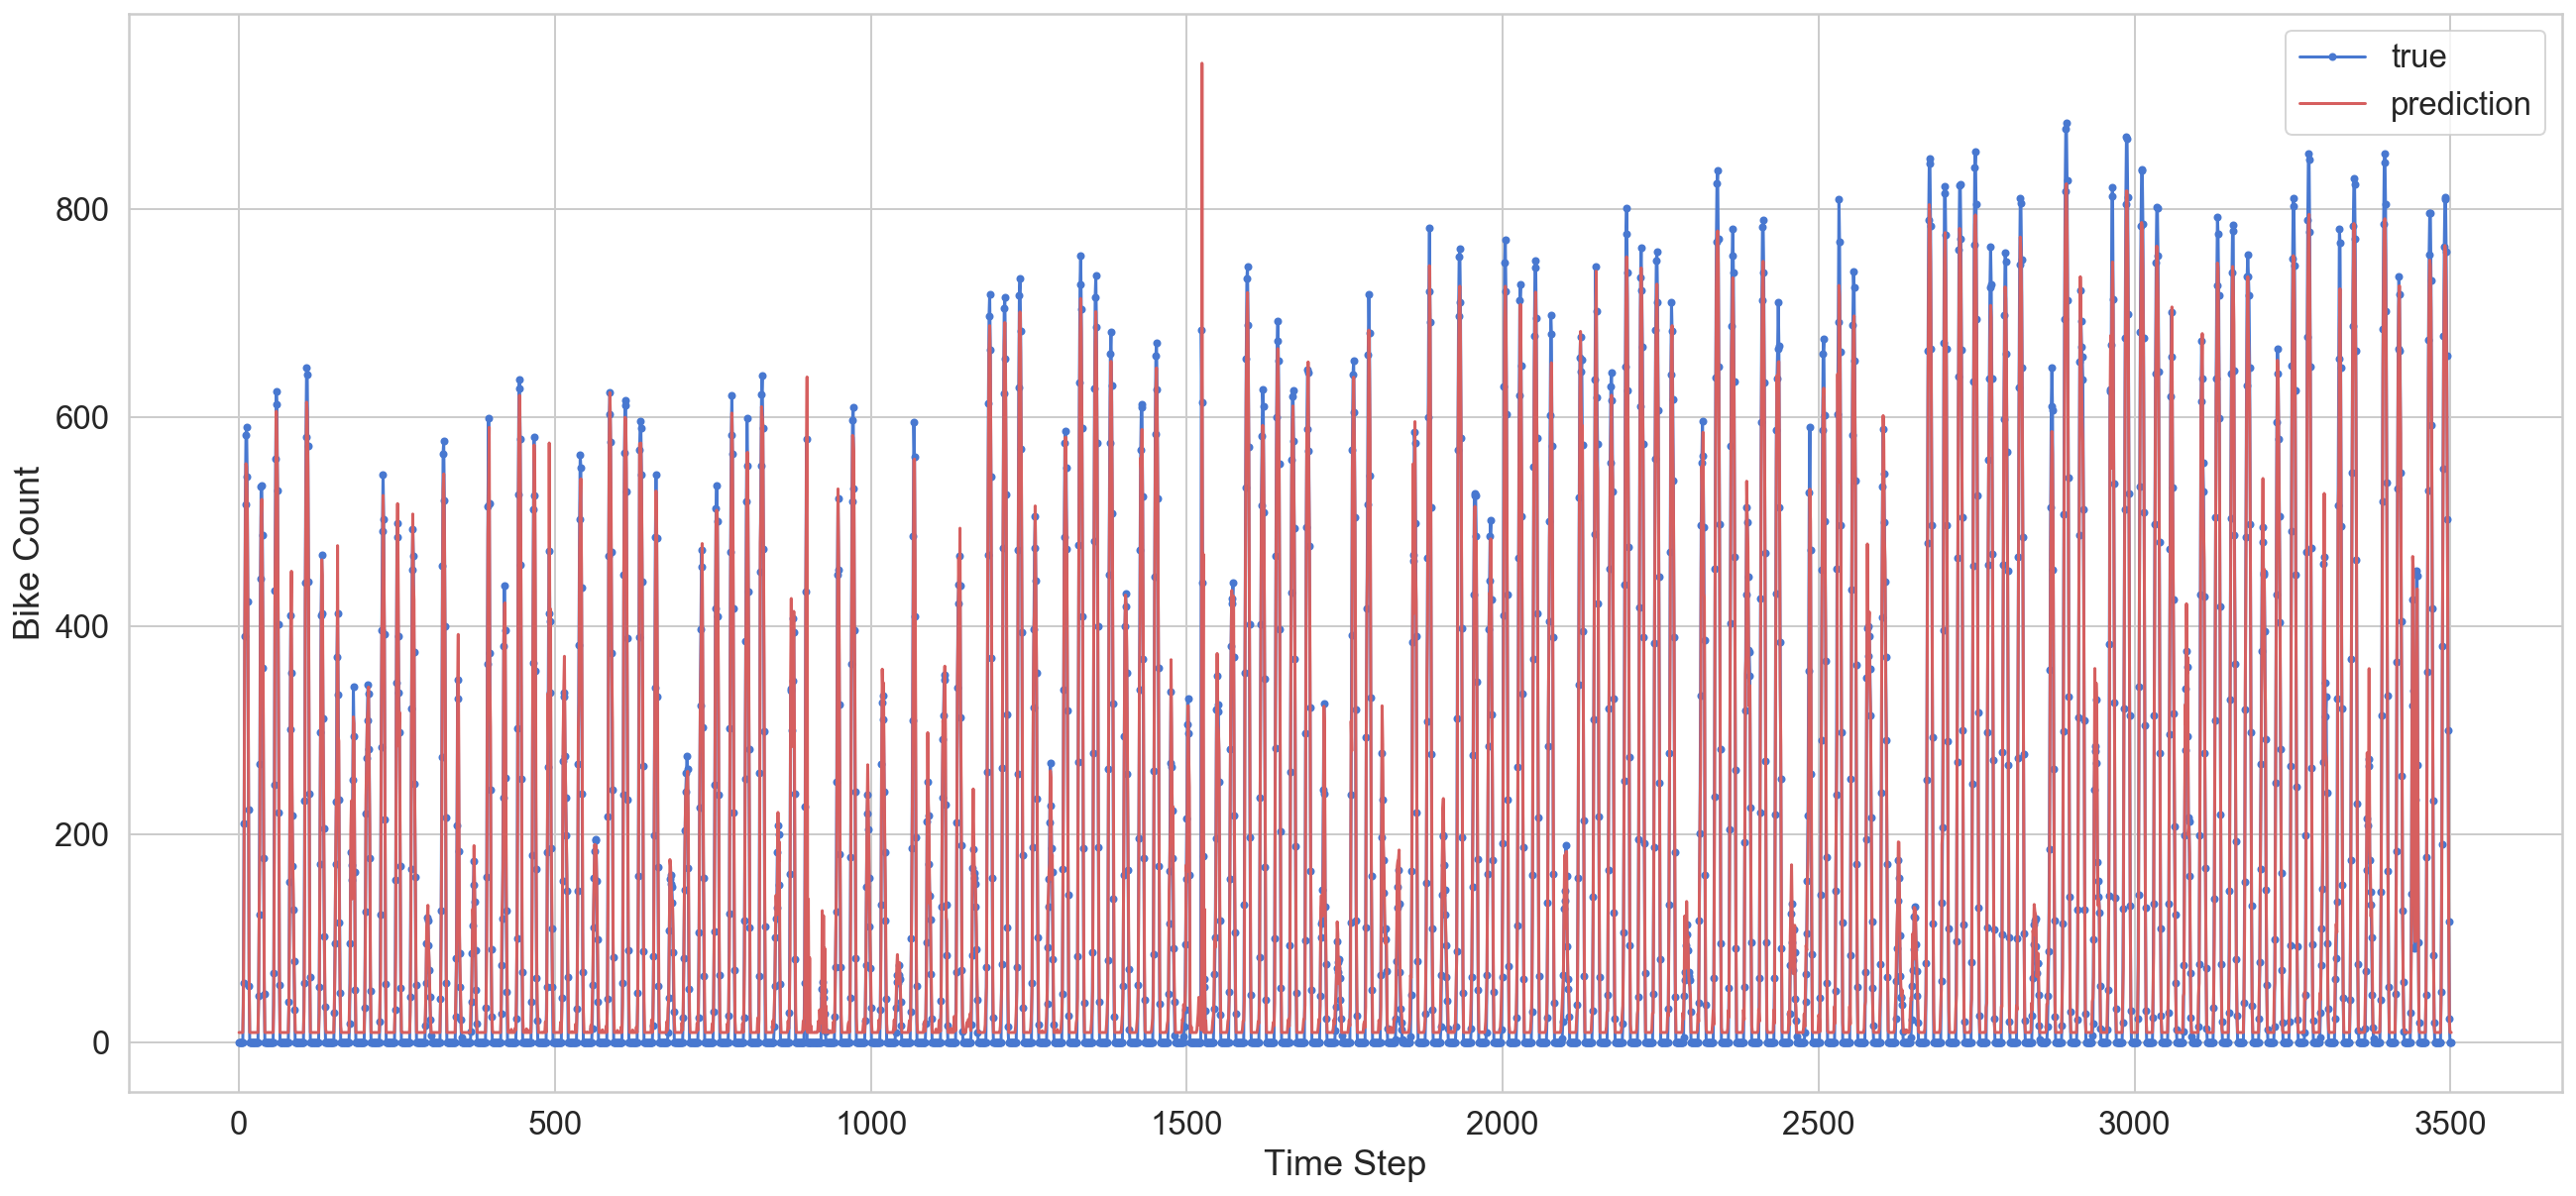

In [43]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('value predict')
plt.xlabel('Time Step')
plt.legend()
plt.show();